# MVP Comunidad Valenciana with Target Encoding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

# Using Activo and Baja for 0 and 1    
class_names = ['Activo','Baja']

pd.options.display.max_columns = None

%matplotlib inline

In [2]:
data = pd.read_excel('../data/portfolio_com_valencia.xlsx')
data['Cliente'] = data['Cliente'].astype('str')
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53


In [3]:
data.shape

(55227, 24)

## Feature engineering

- Edad en Años
- Rango de Income Amount
- Días Activo escalado
- Escalado de 'Quejas' y 'MT

Rangos de Edad:

In [4]:
data.columns

Index(['Start Date', 'Cliente', 'Client Type', 'Modelo', 'Provincia', 'Gender',
       'Nationality', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Status Date',
       'Status', 'Property Type', 'Financiado', 'Rango Precio',
       'Resumen Precio', 'Precio Contado', 'Precio Total',
       'Precio Mensualidad', 'Quejas', 'Incidencias'],
      dtype='object')

In [5]:
data['Born Date'].isnull().sum()

226

In [6]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53


In [7]:
data['Born Date'].isnull().sum()

0

In [8]:
# Edad actual si OP y edad cuando se dio de baja si BAJA

data['Edad'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Status Date'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096


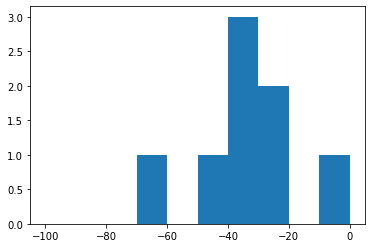

In [9]:
plt.hist(data['Edad'], range = (-100,0));

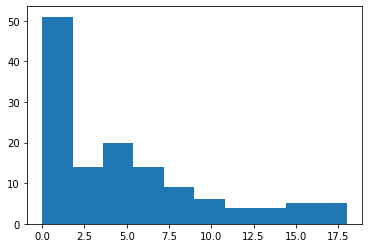

In [10]:
plt.hist(data['Edad'], range = (0,18));

In [11]:
data['Edad'].mean()

52.30124380793465

In [12]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

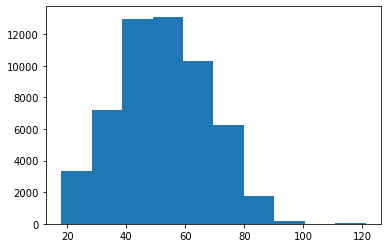

In [13]:
plt.hist(data['Edad']);

In [14]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30


In [15]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Status"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Status,0,1,All,0,1
Rango_Edad,,,,,
+80,1602,319,1921,0.833941,0.166059
18-30,2516,1582,4098,0.613958,0.386042
30-40,4622,3306,7928,0.582997,0.417003
40-50,8795,4081,12876,0.683054,0.316946
50-60,9820,2748,12568,0.781349,0.218651
60-70,8380,1489,9869,0.849124,0.150876
70-80,5202,765,5967,0.871795,0.128205
All,40937,14290,55227,0.741250,0.258750


Rangos de Income Amount:

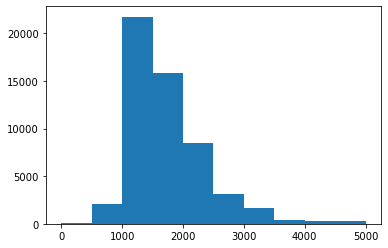

In [16]:
plt.hist(data['Income Amount'], range=(0, 5000));

In [17]:
# Mapping Income Amount
data.loc[data['Income Amount'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Income Amount'] > 1000) & (data['Income Amount'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Income Amount'] > 1500) & (data['Income Amount'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Income Amount'] > 2000) & (data['Income Amount'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Income Amount'] > 3000, 'Income'] = "+3000"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000


In [18]:
tab1 = pd.crosstab(data["Income"], data["Status"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Status,0,1,All,0,1
Income,,,,,
+3000,1687,448,2135,0.790164,0.209836
0-1000,6979,3147,10126,0.689216,0.310784
1000-1500,18436,6408,24844,0.742071,0.257929
1500-2000,9482,3084,12566,0.754576,0.245424
2000-3000,4353,1203,5556,0.783477,0.216523
All,40937,14290,55227,0.741250,0.258750


Días Activo:

In [19]:
# Días hasta el 19/01/2021 si OP y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Start Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Start Date']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Status Date'] - data.loc[i,'Start Date']).days
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165


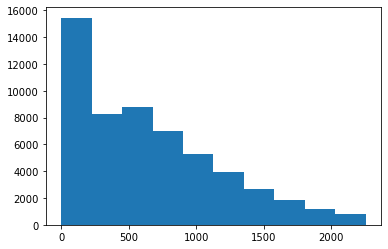

In [20]:
plt.hist(data['Dias_Activo']);

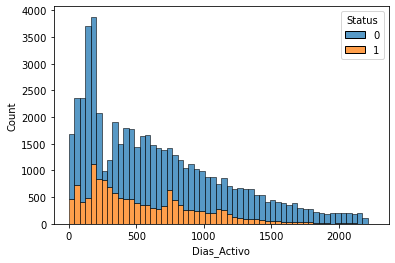

In [21]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Status', multiple = 'stack')

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Dias_Activo_sca'] = scaler.fit_transform(data['Dias_Activo'].values.reshape(-1, 1))

data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630


In [23]:
filename = '../mvp_pkl/dias_activo_sca.pkl'
dias_activo_sca = scaler.fit(data['Dias_Activo'].values.reshape(-1, 1))

pickle.dump(dias_activo_sca, open(filename,'wb'))

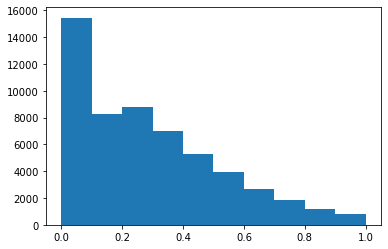

In [24]:
plt.hist(data['Dias_Activo_sca']);

Escalado de Quejas y Missing Test (MT):

In [25]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694,0.035714
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701,0.000000
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978,0.035714
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271,0.035714
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630,0.000000


In [26]:
filename = '../mvp_pkl/quejas_sca.pkl'
quejas_sca = scaler.fit(data['Quejas'].values.reshape(-1, 1))

pickle.dump(quejas_sca, open(filename,'wb'))

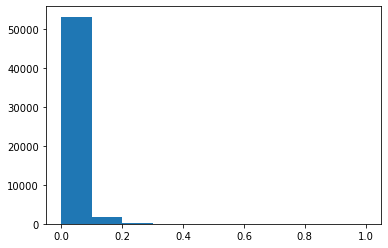

In [27]:
plt.hist(data['Quejas_sca']);

In [28]:
scaler = MinMaxScaler()
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,2015-01-02,17,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,2017-09-15,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694,0.035714,0.000000
1,2015-01-03,58,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,2017-12-31,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701,0.000000,0.000000
2,2015-01-05,91,Normal,V1,Valencia,HOMBRE,ES - ESPAÑOLA,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,2018-02-28,1,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978,0.035714,0.000000
3,2015-01-05,111,Normal,V1,Alicante,HOMBRE,ES - ESPAÑOLA,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271,0.035714,0.000000
4,2015-01-05,118,Normal,V1,Alicante,MUJER,ES - ESPAÑOLA,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,2018-03-15,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630,0.000000,0.194853


In [29]:
filename = '../mvp_pkl/incidencias_sca.pkl'
mt_sca = scaler.fit(data['Incidencias'].values.reshape(-1, 1))

pickle.dump(mt_sca, open(filename,'wb'))

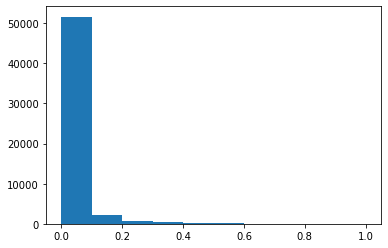

In [30]:
plt.hist(data['Incidencias_sca']);

## Enconding con ``target encoding``

In [31]:
data.columns

Index(['Start Date', 'Cliente', 'Client Type', 'Modelo', 'Provincia', 'Gender',
       'Nationality', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Status Date',
       'Status', 'Property Type', 'Financiado', 'Rango Precio',
       'Resumen Precio', 'Precio Contado', 'Precio Total',
       'Precio Mensualidad', 'Quejas', 'Incidencias', 'Edad', 'Rango_Edad',
       'Income', 'Dias_Activo', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca'],
      dtype='object')

In [32]:
data_filtered = data[['Gender', 'Housing Type', 'Property Type', 'Labor Situation', 'Marital Status',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Precio', 'Number Pay', 'Dias_Activo_sca',
                      'Quejas_sca', 'Incidencias_sca', 'Status']]
data_filtered.columns

Index(['Gender', 'Housing Type', 'Property Type', 'Labor Situation',
       'Marital Status', 'Provincia', 'Nationality', 'Rango_Edad', 'Income',
       'Rango Precio', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Status'],
      dtype='object')

In [33]:
X = data_filtered.drop(['Status'],axis=1)
y = data_filtered['Status']

In [34]:
from sklearn.model_selection import train_test_split
X_train_prev, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [35]:
features_TE = ['Gender', 'Housing Type', 'Property Type', 'Labor Situation', 'Marital Status',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Precio', 'Number Pay']

In [36]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

In [37]:
X_train_prev.head()

,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
25918,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,"Chalet, villa",07 PENSIONISTA (JUBILACION),2 - CASADO,Alicante,ES - ESPAÑOLA,60-70,0-1000,Entre 000-050,12,0.352993,0.035714,0.000000
5305,HOMBRE,5 - EMPRESA,Apartamento,04 AUTONOMO,2 - CASADO,Alicante,ES - ESPAÑOLA,40-50,1000-1500,Entre 000-050,14,0.756984,0.000000,0.000000
38504,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,"Chalet, villa",01 ASALARIADO FIJO,2 - CASADO,Alicante,UE - UNION EUROPEA,50-60,1500-2000,Entre 000-050,14,0.178714,0.000000,0.000000
35496,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,Apartamento,07 PENSIONISTA (JUBILACION),3 - VIUDO,Alicante,ES - ESPAÑOLA,+80,1000-1500,Entre 050-100,12,0.228381,0.000000,0.000000
8046,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,Apartamento,04 AUTONOMO,2 - CASADO,Valencia,ES - ESPAÑOLA,60-70,1000-1500,Entre 050-100,14,0.678936,0.000000,0.007353


In [38]:
TE_encoder.fit(X_train_prev, y_train)
X_train = TE_encoder.transform(X_train_prev)
X_train.head()

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
25918,0.2536,0.229333,0.207625,0.144286,0.219234,0.220812,0.254659,0.150285,0.311213,0.326792,0.282987,0.352993,0.035714,0.000000
5305,0.2536,0.272727,0.210947,0.337908,0.219234,0.220812,0.254659,0.318098,0.257715,0.326792,0.234842,0.756984,0.000000,0.000000
38504,0.2536,0.229333,0.207625,0.224191,0.219234,0.220812,0.250320,0.219219,0.244343,0.326792,0.234842,0.178714,0.000000,0.000000
35496,0.2536,0.229333,0.210947,0.144286,0.183570,0.220812,0.254659,0.160261,0.257715,0.237826,0.282987,0.228381,0.000000,0.000000
8046,0.2536,0.229333,0.210947,0.337908,0.219234,0.272935,0.254659,0.150285,0.257715,0.237826,0.234842,0.678936,0.000000,0.007353


In [39]:
filename = '../mvp_pkl/TE_encoder.pkl'

pickle.dump(TE_encoder.fit(X_train_prev, y_train), open(filename,'wb'))

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [40]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
15591,0.253600,0.229333,0.210947,0.337908,0.370321,0.272935,0.254659,0.150285,0.244343,0.326792,0.282987,0.523282,0.000000,0.000000
27726,0.278034,0.229333,0.210947,0.337908,0.370321,0.272935,0.254659,0.415079,0.257715,0.185057,0.234842,0.321951,0.000000,0.000000
16792,0.253600,0.229333,0.207625,0.460733,0.219234,0.220812,0.254659,0.150285,0.257715,0.326792,0.234842,0.502439,0.000000,0.000000
23233,0.253600,0.229333,0.210947,0.337908,0.219234,0.343207,0.254659,0.318098,0.257715,0.308267,0.234842,0.276275,0.035714,0.147059
24836,0.253600,0.229333,0.207625,0.224191,0.219234,0.343207,0.254659,0.318098,0.244343,0.237826,0.234842,0.369845,0.000000,0.000000


### Regresión Logística

Logistic Accuracy is 0.74
Cross Validation Score = 0.74
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      8188
           1       0.50      0.71      0.59      2858

    accuracy                           0.74     11046
   macro avg       0.69      0.73      0.70     11046
weighted avg       0.78      0.74      0.75     11046



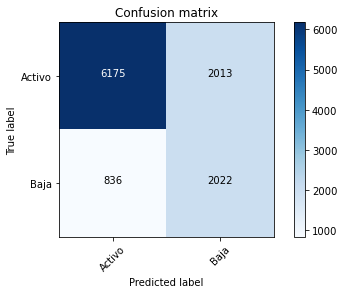

In [41]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state = 0, max_iter=1000, class_weight="balanced")
LR.fit(X_train,y_train) 
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, LR.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_LR = cross_val_score(LR, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_LR)

y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.80


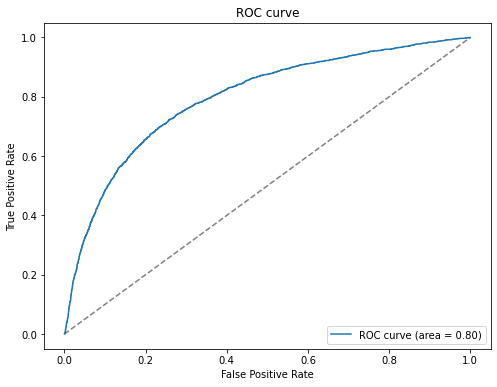

In [42]:
plot_roc_curve(LR, X_test, y_test)

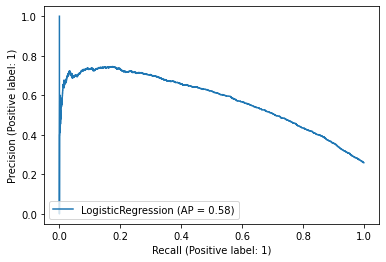

In [43]:
plot_precision_recall_curve(LR, X_test, y_test);

In [44]:
filename = '../mvp_pkl/LR_model.pkl'
LR_model = LR.fit(X_train, y_train)

pickle.dump(LR_model, open(filename,'wb'))

### KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
# Don´t do this!!!

skf = StratifiedKFold(n_splits=5)
knn = GridSearchCV(KNeighborsClassifier(),
                      param_grid = {'n_neighbors':np.arange(3,17,2)},
                      scoring = 'recall', cv = skf)

knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15])},
             scoring='recall')

In [50]:
knn.best_params_

{'n_neighbors': 3}

In [46]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [47]:
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      8188
           1       0.60      0.45      0.51      2858

    accuracy                           0.78     11046
   macro avg       0.71      0.67      0.69     11046
weighted avg       0.77      0.78      0.77     11046



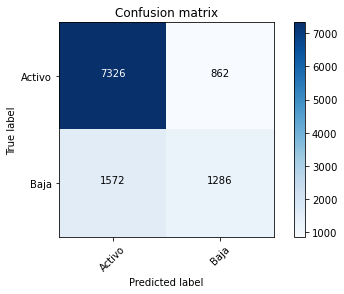

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.74


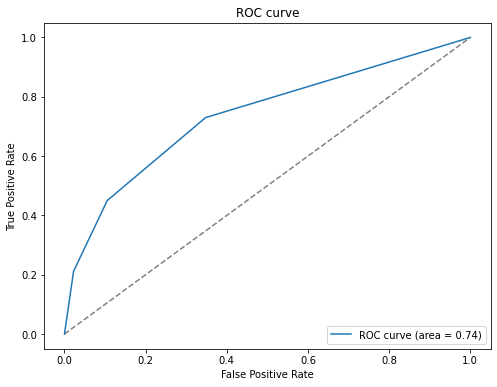

In [49]:
plot_roc_curve(knn, X_test, y_test)

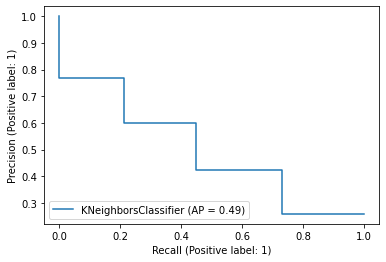

In [50]:
plot_precision_recall_curve(knn, X_test, y_test);

### Decission Tree Classifier

Decision Tree Accuracy is 0.74
Cross Validation Score = 0.74
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      8188
           1       0.50      0.71      0.58      2858

    accuracy                           0.74     11046
   macro avg       0.69      0.73      0.70     11046
weighted avg       0.78      0.74      0.75     11046



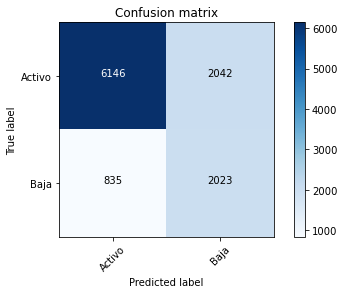

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

DT = DecisionTreeClassifier(random_state = 0,class_weight="balanced", min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_DT = cross_val_score(DT, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_DT)

y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.80


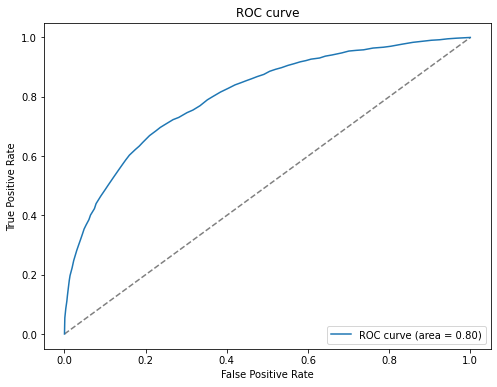

In [52]:
plot_roc_curve(DT, X_test, y_test)

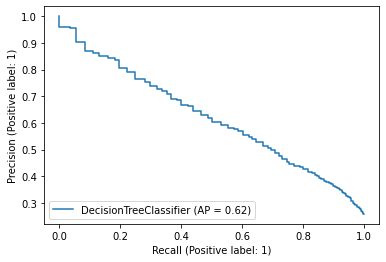

In [53]:
plot_precision_recall_curve(DT, X_test, y_test);

In [54]:
filename = '../mvp_pkl/DT_model.pkl'
DT_model = DT.fit(X_train, y_train)

pickle.dump(DT_model, open(filename,'wb'))

### Random Forest Classifier

Random Forest Accuracy is 0.82
Cross Validation Score = 0.81
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      8188
           1       0.65      0.63      0.64      2858

    accuracy                           0.82     11046
   macro avg       0.76      0.76      0.76     11046
weighted avg       0.81      0.82      0.81     11046



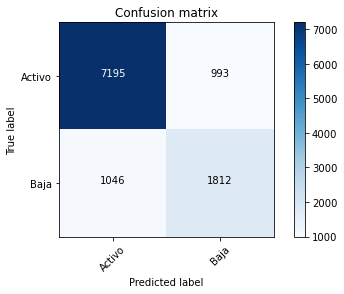

In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, rfc.predict(X_test)))

skf = StratifiedKFold(n_splits=20)
score_rfc = cross_val_score(rfc, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc)

y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [56]:
filename = '../mvp_pkl/rfc_model.pkl'
rfc_model = rfc.fit(X_train, y_train)

pickle.dump(rfc_model, open(filename,'wb'))

ROC AUC score: 0.85


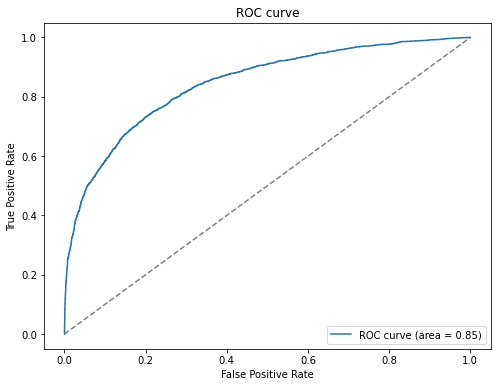

In [57]:
plot_roc_curve(rfc, X_test, y_test)

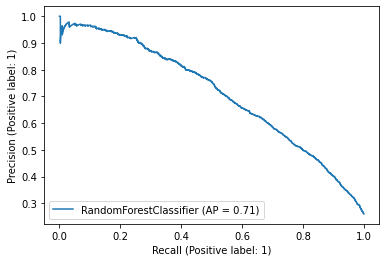

In [58]:
plot_precision_recall_curve(rfc, X_test, y_test);

### XGBoost

GradientBoost Accuracy= 0.83
Cross Validation Score = 0.83
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      8188
           1       0.77      0.52      0.62      2858

    accuracy                           0.83     11046
   macro avg       0.81      0.73      0.76     11046
weighted avg       0.83      0.83      0.82     11046



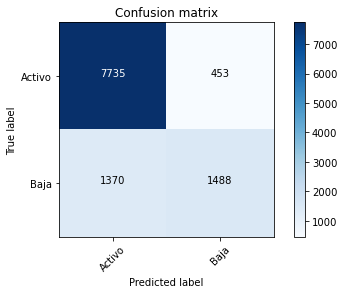

In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, booster='gbtree', learning_rate=0.01, objective='binary:logistic')
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_xgb = cross_val_score(xgb, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_xgb)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.86


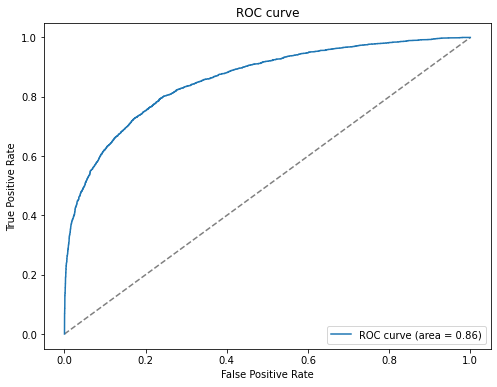

In [60]:
plot_roc_curve(xgb, X_test, y_test)

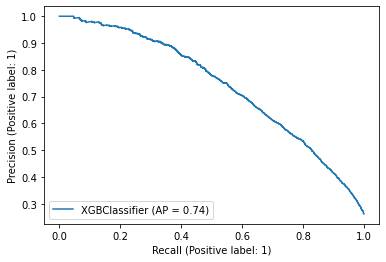

In [61]:
plot_precision_recall_curve(xgb, X_test, y_test);

### Comparing ROC Curves

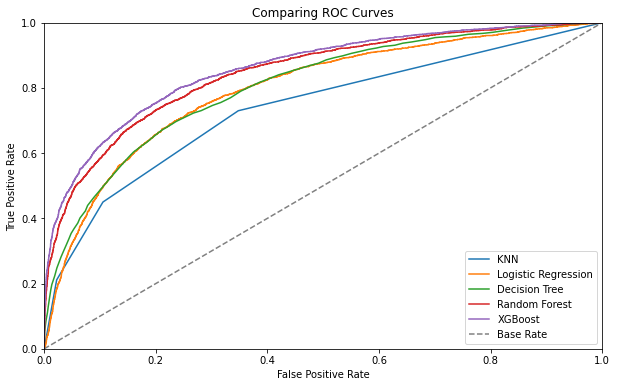

In [62]:
plt.figure(figsize = (10,6), linewidth= 1)

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.plot(knn_fpr, knn_tpr, label='KNN' )
plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')

plt.plot([0,1],[0,1],label='Base Rate', ls = '--', c = 'grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparing PR Curves

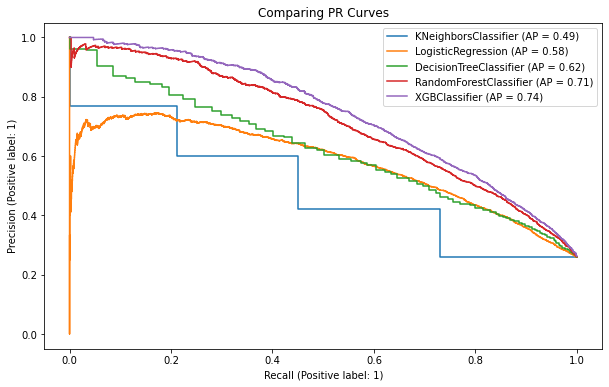

In [63]:
models = [knn, LR, DT, rfc, xgb]

fig, ax = plt.subplots(figsize=(10, 6))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
    plt.legend(loc="upper right")
ax.set_title("Comparing PR Curves");

### Feature importances

In [64]:
from sklearn.feature_selection import RFE

# Using Recursive Feature Elimination Function and fitting it in a Logistic Regression Model
modell = LogisticRegression(max_iter=1000, class_weight="balanced")
rfe = RFE(modell, 5)
rfe = rfe.fit(X_train,y_train)

rfe.ranking_

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 8,  5,  2,  7,  3,  6,  4,  1,  1,  1, 10,  9,  1,  1])

In [65]:
result = zip(X_train.columns, rfe.ranking_)

result_set = set(result)
print(result_set)

{('Rango_Edad', 1), ('Nationality', 4), ('Rango Precio', 1), ('Quejas_sca', 1), ('Labor Situation', 7), ('Housing Type', 5), ('Number Pay', 10), ('Income', 1), ('Dias_Activo_sca', 9), ('Provincia', 6), ('Property Type', 2), ('Incidencias_sca', 1), ('Marital Status', 3), ('Gender', 8)}


[0.0245376  0.03942751 0.09383085 0.0514014  0.03663735 0.04239976
 0.03972628 0.07523907 0.06884252 0.068357   0.04560377 0.22428611
 0.08212991 0.10758087]


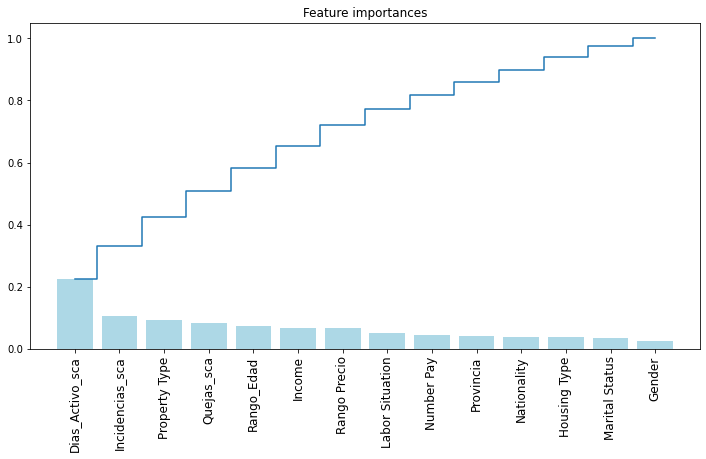

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Printing important features in the model
print(model.feature_importances_)
importances = model.feature_importances_
feat_names = data_filtered.drop(['Status'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()